<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель Факультета Компьютерных Наук НИУ ВШЭ <br> Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 8. Продвинутые методы классификации и регрессии. Xgboost</center>
## <center>Часть 1. Бустинг, градиентный бустинг и Xgboost</center>

Бустинг представляет собой жадный алгоритм построения композиции алгоритмов. Основная идея заключается в том, чтобы, имея множество относительно слабых алгоритмов обучения, построить их хорошую линейную комбинацию. Он похож на бэггинг тем, что базовый алгоритм обучения фиксирован. Отличие состоит в том, что обучение базовых алгоритмов для композиции происходит итеративно, и каждый следующий алгоритм стремится компенсировать недостатки композиции всех предыдущих алгоритмов.

На примере бустинга стало ясно, что хорошим качеством могут обладать сколь угодно сложные композиции классификаторов, при условии, что они правильно настраиваются. Это развеяло существовавшие долгое время представления о том, что для повышения обобщающей способности необходимо ограничивать сложность алгоритмов. 

Впоследствии этот феномен бустинга получил теоретическое обоснование. Оказалось, что взвешенное голосование не увеличивает эффективную сложность алгоритма, а лишь сглаживает ответы базовых алгоритмов. Эффективность бустинга объясняется тем, что по мере добавления базовых алгоритмов увеличиваются отступы обучающих объектов. Причём бустинг продолжает раздвигать классы даже после достижения безошибочной классификации обучающей выборки.

Общая схема бустинга:
- Искомый ансамбль алгоритмов имеет вид $a(x) = \mbox{sign}(\sum_{t = 1}^T \alpha_t b_t(x))$, где $b_t$ - базовые алгоритмы.
- Ансамбль строится итеративно, оптимизируя на каждом шаге функционал $Q_t$, равный количеству ошибок текущей композиции на обучающей выборке.
- При добавлении слагаемого $\alpha_t b_t(x)$ в сумму, функционал $Q_t$ оптимизируется только по базовому алгоритму $b_t(x)$ и коэффициенту $\alpha_t$ при нём, все предыдущие слагаемые считаются фиксированными.
- Функционал $Q_t$ имеет вид суммы по объектам обучающей выборки пороговых функций вида $[y_i \sum_{j = 1}^t \alpha_j b_j(x_i) < 0]$, имеющих смысл "текущая композиция ошибается на объекте с номером $i$". Каждое такое слагаемое имеет вид "ступеньки" и является разрывной функцией. Для упрощения решения задачи оптимизации такая пороговая функция заменяется на непрерывно дифференцируемую оценку сверху. В итоге получается новый функционал $\hat{Q}_t \geqslant Q_t$, минимизация которого приводит к минимизации исходного функционала $Q_t$.

Используя различные аппроксимации для пороговой функции потерь $[z < 0]$, будем получать различные виды бустинга. Примеры:
- $e^{-z}$ - AdaBoost
- $\log_2(1 + e^{-z})$ - LogitBoost
- $(1 - z)^2$ - GentleBoost
- $e^{-cz(z+a)}$ - BrownBoost
- другие

In [8]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline

import xgboost as xgb

import numpy as np
import sys
if sys.version_info.major == 2:
    from urllib import urlopen
if sys.version_info.major == 3:    
    from urllib.request import urlopen
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris, load_digits, load_boston

Populating the interactive namespace from numpy and matplotlib


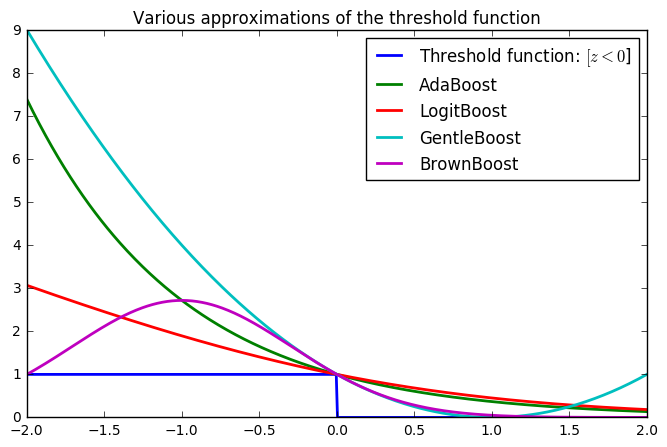

In [9]:
x = np.linspace(-2, 2, 500)

plt.figure(figsize=(8,5))
plt.plot(x, x < 0, lw=2, label='Threshold function: $[z < 0$]')
plt.plot(x, np.exp(-x), lw=2, label='AdaBoost')
plt.plot(x, np.log2(1 + np.exp(-x)), lw=2, label='LogitBoost')
plt.plot(x, (1 - x) ** 2, lw=2, label='GentleBoost')
plt.plot(x, np.exp(-x * (x + 2)), lw=2, label='BrownBoost')
plt.title('Various approximations of the threshold function')
plt.legend(loc='best');

# Алгоритм AdaBoost

Как было сказано, алгоритм AdaBoost получается из описанной схемы, при аппроксимации пороговой функции потерь с помощью функции $e^{-z}$. Cуществует теорема (Freund, Schapire, 1996), дающая для достаточно богатых семейств базовых классификаторов явные формулы для базового алгоритма $b_t(x)$ и коэффициента $\alpha_t$ при нём, на которых достигается минимум функционала $\hat{Q}_t$. 

Сам алгоритм выглядит следующим образом:
- Инициализировать веса объектов $\Large w_i^{(0)} = \frac{1}{l}, i = 1, \dots, l$.
- Для всех $t = 1, \dots, T$
    * Обучить базовый алгоритм $\Large b_t$, пусть $\epsilon_t$ - его ошибка на обучающей выборке.
    * $\Large \alpha_t = \frac{1}{2}ln\frac{1 - \epsilon_t}{\epsilon_t)}$.
    * Обновить веса объектов: $\Large w_i^{(t)} = w_i^{(t-1)} e^{-\alpha_t y_i b_t(x_i)}, i = 1, \dots, l$.
    * Нормировать веса объектов: $\Large w_0^{(t)} = \sum_{j = 1}^k w_j^{(t)}, w_i^{(t)} = \frac{w_i^{(t)}}{w_0^{(t)}}, i = 1, \dots, l$.
- Вернуть $\sum_t^{T}\alpha_tb_t$

Таким образом, вновь добавляемый алгоритм обучается путём минимизации взвешенной частоты ошибок на обучающей выборке, а не стандартного функционала, равного частоте ошибок. Вес объекта увеличивается в $e^{\alpha_t}$ раз, когда $b_t$ допускает на нём ошибку, и уменьшается во столько же раз, когда $b_t$ правильно классифицирует этот объект. Таким образом, непосредственно перед настройкой базового алгоритма наибольший вес накапливается у тех объектов, которые чаще оказывались трудными для классификации предыдущими алгоритмами.

### Пример для иллюстрации 
Пусть базовые алгоритмы - всего лишь "пеньки" - деревья решений глубины 1.
<img src='../../img/adaboost_toy_step1.png'>
Веса объектов, на которых базовый алгоритм ошибается, увеличиваются (кружки увеличиваются в размере).
<img src='../../img/adaboost_toy_step2.png'>
В конце базовые алгоритмы "голосуют", их веса определялись $\alpha_t$ в процессе построения.
<img src='../../img/adaboost_toy_step3.png'>

<img src="../../img/boosting_overfitting.png">

Сначала было обнаружено отстутствие переобучения бустинга вплоть до 1000 базовых классификаторов, похже это было теоретически обосновано. 

# Градиентный бустинг
Метод градиентного бустинга в некотором смысле является обобщением остальных методов бустинга, поскольку он позволяет оптимизировать произвольную дифференцируемую функцию потерь. Данный алгоритм похож на метод градиентного спуска, применяемый для решения задач оптимизации. Основная идея заключается в том, что каждый следующий добавляемый в композицию алгоритм настраивается на остатки предыдущих алгоритмов.

Пусть дана функция потерь дифференцируемая $\Large L(F(x), y)$. Сам алгоритм выглядит следующим образом:
- Инициализация композиции константным значением $\Large F_0(x) = \arg\min_{\alpha} \sum_{i=1}^n L(\alpha, y_i)$.
- Для всех $\Large t = 1, \dots, T$:
    * Вычислить остатки предыдущей композиции: $\Large r_{it} = -[\nabla_{F(x)} L(F(x_i), y_i)]_{F(x) = F_{t-1}(x)}, i = 1, \dots, n$.
    * Настроить базовый алгоритм $\Large b_t(x)$ на полученные остатки, т.е. обучить его по выборке $\Large \{(x_i, r_{it}), i = 1, \dots, n\}$.
    * Вычислить коэффициент $\alpha_t$ перед базовым алгоритмом $\Large b_t(x)$ как решение следующей одномерной задачи оптимизации:
    $\Large \alpha_t = \arg\min_\alpha \sum_{i=1}^n L(F_{t-1}(x_i) + \alpha b_t(x_i), y_i)$.
    * Добавить полученное слагаемое в композицию: $\Large F_t(x) = F_{t-1}(x) + \alpha_t b_t(x)$.
    
Одной из возможных модификаций данного алгоритма является стохастический градиентный бустинг (SGB), который заключается в том, чтобы вычислять суммы вида $\sum_{i=1}^n$ не по всей обучающей выборке, а только по некоторой её случайной подвыборке. Такой подход является одним из способов регуляризации данного алгоритма и позволяет улучшить качество композиции, сходимость алгоритма и время обучения. 

Другой способ регуляризации - это введение параметра $\gamma$, называемого темпом обучения. При добавлении нового слагаемого в композицию, будем добавлять его, умноженное на этот коэффициент. Как правило, чем меньше темп обучения, тем лучше качество итоговой композиции.

Для задач регресси обычно использую квадратичную функцию потерь $L(x, y) = (x - y)^2$ или модуль отклонения $L(x, y) = |x - y|$.
В задаче классификации используется логистическая функция потерь, которая позволяет возвращать вероятности принадлежности объектов к классам.

Одним из наиболее популярных семейств базовых алгоритмов являются решающие деревья. Именно такой вариант градиентного бустинга <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html">реализован</a> в sklearn.

# Xgboost

Проблема многих алгоримтов построения деревьев в том, что в них не уделяется должного внимания регуляризации. 
В классическом градиентном бустинге применяется такие меры:
- ограничение на структуру дерева: макисмальная глубина (max_depth), минимальное число объектов в листе (min_samples_leaf)
- контролирование темпа обучения (learning_rate)
- увеличение "непохожести" деревьев за счет рандомизации, как в слачайном лесе

[Xgboost](https://github.com/dmlc/xgboost) использует еще больше параметров для регуляризации базовых деревьев.

Целевая функция для оптимизации в Xgboost состоит из двух слагаемых: специфичной пункции потерь и регуляризатора $\Omega (f_k)$ для каждого из $K$ деревьев, где $f_k$ - прогноз $k$-ого дерева.


$$
obj(\theta) = \sum_{i}^{\ell} l(y_i - \hat{y_i}) +  \sum_{k=1}^{K} \Omega (f_k)
$$

Функция потерь зависит от решаемой задачи (Xgboost адаптирован для под задачи классификации, регрессии и ранжирования, подробней хорошо описано в [документации](http://xgboost.readthedocs.io/) Xgboost), а регуляризатор выглядит следующим образом:

$$
\Omega(f) = \gamma T + \frac{1}{2} \lambda \sum_{j=1}^{T}w_j^2
$$

Первое слагаемое ($\gamma T$) штрафует модель за большое число листьев $T$, а второе ($\frac{1}{2} \lambda \sum_{j=1}^{T}w_j^2$) контролирует сумму весов модели в листьях. 

# Примеры

В sklearn доступны алгоритмы AdaBoost и GradientBoosting для задач классификации и регрессии.
В качестве примера рассмотрим решение задачи восстановления одномерной регрессии с помощью <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html">GradientBoostingRegressor</a>.

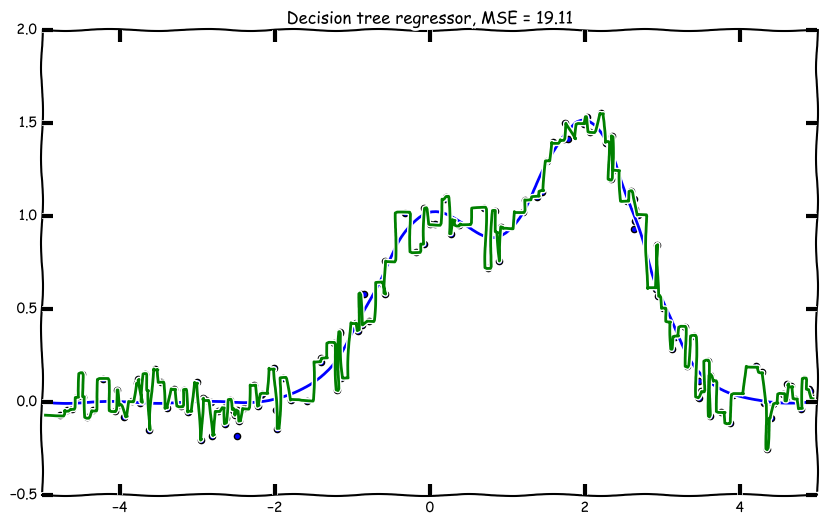

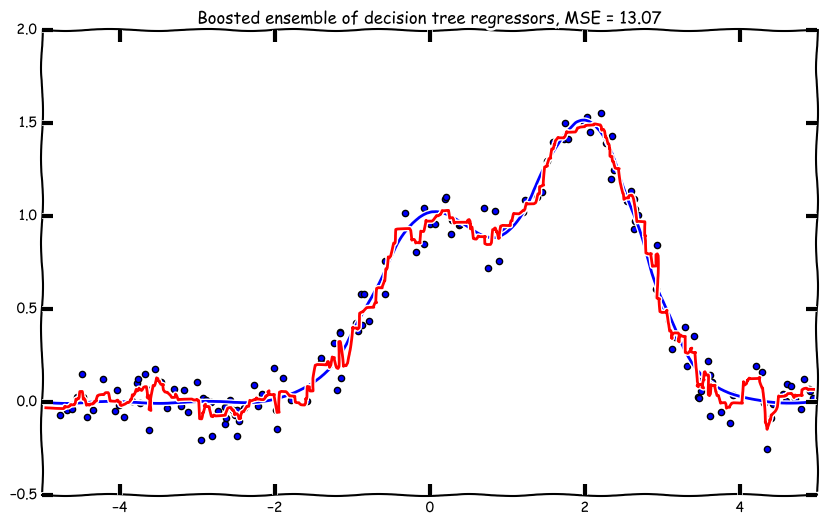

In [10]:
n_train = 150        
n_test = 1000       
noise = 0.1

# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) +\
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)
# One decision tree regressor
dtree = DecisionTreeRegressor(random_state=42)

dtree.fit(X_train, y_train)
d_predict = dtree.predict(X_test)

with plt.xkcd():
    plt.figure(figsize=(10, 6))
    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, d_predict, "g", lw=2)
    plt.xlim([-5, 5])
    plt.title("Decision tree regressor, MSE = %.2f" % 
              np.sum((y_test - d_predict) ** 2))

    gbtree = GradientBoostingRegressor(n_estimators=100, subsample=0.5,
                                      random_state=42)  
    gbtree.fit(X_train, y_train)
    gb_predict = gbtree.predict(X_test)

    plt.figure(figsize=(10, 6))
    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, gb_predict, "r", lw=2)
    plt.xlim([-5, 5])
    plt.title("Boosted ensemble of decision tree regressors, MSE = %.2f" % 
              np.sum((y_test - gb_predict) ** 2));

Рассмотрим пример использования AdaBoostClassifier с деревья решений единичной глубины (decision stumps) в качестве базовых алгоритмов для решения задачи классификации.

In [ ]:
# Loading Pima Indians Diabetes data from UCI Machine learning repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
raw_data = urlopen(url)
data = np.loadtxt(raw_data, delimiter=",")

X_train, X_test, y_train, y_test = train_test_split(data[:, :8], 
                                                    data[:, 8], 
                                                    random_state=0)

dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

# AdaBoost
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         random_state=42).fit(X_train, y_train)

print("Decision tree accuracy: %.2f" % dt.score(X_test, y_test))
print("AdaBoost accuracy: %.2f" % ada.score(X_test, y_test))

**Пример использования Xgboost для классификации на данных Iris.**

In [4]:
iris = load_iris()
X = iris['data']
y = iris['target']
kf = KFold(n_splits=5, shuffle=True, random_state=13)
for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBClassifier().fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(confusion_matrix(actuals, predictions))

[[ 9  0  0]
 [ 0  8  0]
 [ 0  2 11]]
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
[[9 0 0]
 [0 9 1]
 [0 2 9]]
[[12  0  0]
 [ 0 10  1]
 [ 0  0  7]]
[[10  0  0]
 [ 0 11  0]
 [ 0  0  9]]


**Пример восстановления регрессии с Xgboost на данных boston.**

In [5]:
boston = load_boston()
y = boston['target']
X = boston['data']
kf = KFold(n_splits=5, shuffle=True, random_state=17)
for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBRegressor().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(mean_squared_error(actuals, predictions))

8.0971394504
8.92640647601
18.299771839
6.73819144817
8.47392580766


**Простой пример подбора параметров с GridSearchCV.**

In [6]:
X = boston['data']
y = boston['target']

xgb_model = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)
xgb_grid.fit(X,y)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
0.598487960649
{'n_estimators': 100, 'max_depth': 4}


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    4.8s finished


**Ранняя остановка используется для того, чтобы прекратить обучение модели (градиентный спуск), если ошибка за несколько итераций не уменьшилась.**

In [7]:
digits = load_digits()

X = digits['data']
y = digits['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="merror",
        eval_set=[(X_test, y_test)])

[0]	validation_0-merror:0.168889
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.162222
[2]	validation_0-merror:0.151111
[3]	validation_0-merror:0.142222
[4]	validation_0-merror:0.131111
[5]	validation_0-merror:0.128889
[6]	validation_0-merror:0.124444
[7]	validation_0-merror:0.111111
[8]	validation_0-merror:0.113333
[9]	validation_0-merror:0.111111
[10]	validation_0-merror:0.111111
[11]	validation_0-merror:0.111111
[12]	validation_0-merror:0.106667
[13]	validation_0-merror:0.113333
[14]	validation_0-merror:0.108889
[15]	validation_0-merror:0.104444
[16]	validation_0-merror:0.102222
[17]	validation_0-merror:0.102222
[18]	validation_0-merror:0.102222
[19]	validation_0-merror:0.104444
[20]	validation_0-merror:0.104444
[21]	validation_0-merror:0.1
[22]	validation_0-merror:0.093333
[23]	validation_0-merror:0.086667
[24]	validation_0-merror:0.086667
[25]	validation_0-merror:0.084444
[26]	validation_0-merror:0.088889
[27]	validation_0-merror:0.086

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

## Полезные ссылки
- <a href="https://en.wikipedia.org/wiki/Boosting_(machine_learning)">Boosting</a>
- [Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting)
- [Лекция](http://www.machinelearning.ru/wiki/images/c/cd/Voron-ML-Compositions-slides.pdf) К.В. Воронцова по композиционным методам классификации
- <a href="https://github.com/dmlc/xgboost">Xgboost</a>
- <a href="https://github.com/ChenglongChen/Kaggle_CrowdFlower">Обзор</a> решения победителя соревнования Kaggle "CrowdFlower" по предсказанию релевантности выдачи поисковика товаров. Решение на основе Xgboost